In [123]:
from statsbomb_data_extraction import Game, fetch_matches_for_season, fetch_all_seasons_for_league
from draw_pitch import draw_pitch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression

# xG Model

The concept of "Expected Goals" (xG for short), is a widely used metric among soccer analysts and fans alike. In fact, the idea of xG has infiltrated the mainstream in recent years, to the point where now, even most casual fans have probably heard of the term. The xG metric essentially describes how many goals we'd expect a team to score based on the chances it creates. Each shot a team takes can be assigned an xG value, ranging from 0 to 1, which represents the probability of that shot resulting in a goal. 

The xG metric helps provide objectivity in the analysis of a soccer match, since actual score lines can often be misleading given that luck plays such a large role in the game. If we can see that a team dominated a game by creating many more chances and generating a much larger xG than the other team, this tells us they were probably better on that day, regardless of what the final scoreline may say. Additionally, analyzing xG can help inform play styles, in terms of determining what type of shots are better to take to maximize the probability of scoring a goal.  

This notebook consists in a comprehensive overview of an xG model created using Statsbomb public data. More specifically, the model is creating using data from Barcelona's La Liga matches from 2004 to 2016.

## Notebook Overview

<font size = 4>

1. Fetching data 
    - 1.1 Getting data from Statsbomb
    - 1.2 Extracting shots data and attributes
    
    
2. Data exploration
    - 2.1 Creating new variables
    - 2.2 Separate test and training set
    - 2.3 Visualizing relationships

    
3. Data preprocessing for ML models
    - 2.1 Categorical variables
    - 2.2 Numerical variables
    - 2.3 Combined pipeline
    
    
4. Models
    - 4.1 Logistic regression

## 1. Fetching data

### 1.1 Getting data from Statsbomb. 

To start off, I wrote some functions in the `statsbomb_data_extraction.py` file to get data from statsbomb in the form of json files for each game in a desired season / league. In the cell below, I call `fetch_matches_for_league` with argument **11**, as this corresponds to the La Liga comp in Statsbomb public data. (See [here](https://github.com/statsbomb/open-data/blob/master/data/competitions.json)).

In [2]:
la_liga = fetch_all_seasons_for_league(11)

Getting season 2018/2019...
Getting season 2017/2018...
Getting season 2016/2017...
Getting season 2015/2016...
Getting season 2014/2015...
Getting season 2013/2014...
Getting season 2012/2013...
Getting season 2011/2012...
Getting season 2010/2011...
Getting season 2009/2010...
Getting season 2008/2009...
Getting season 2007/2008...
Getting season 2006/2007...
Getting season 2005/2006...
Getting season 2004/2005...
Done


So we have a data structure, called `la_liga`, which has league season names as the keys of the outer dictionary. The values are dictionaries, which map game ids (as specified by statsbomb) to `Game` objects (see `statsbomb_data_extraction.py` file for Game object definition).

### 1.2 Getting shots data 

Now I will write some functions to parse through the json of each game, and extract all the shots, as well as features related to the shots. In particular, these features are: 

- **play pattern**: pattern of play which led to the shot
- **x start location**: x-location of the shot 
- **y start location**: y-location of the shot 
- **duration**: duration of the shot
- **outcome**: result of the shot
- **technique**: technique with which the shot was hit
- **first time**: whether the shot was hit for time or not
- **x gk position**: x-location of the gk when shot was taken
- **y gk position**: y-location of the gk when shot was taken
- **type of shot**: whether shot was from open play or set piece (and type of set piece specified)
- **num opponents within 5 yards**: number of opponents which were within 5 yards of shot location
- **num opponents between shot and goal**: number of opponents which were between the shot location, and the lines connecting shot location and the two posts

I will also extract some information related to the shot that will be useful to reference the shots, but will not be used to train ML model. These include:
- **game id in which shot was taken**: pattern of play which led to the shot
- **Season of game in which shot was taken**: x-location of the shot 
- **statsbomb xg**: xg given by statsbomb to compare to my values later on

All the variables listed above can be extracted by parsing through the json directly, except for the last one. Therefore, below, I will write a function to get this variable.

In [ ]:
def check_player_btwn_shot_and_goal(x_shot, y_shot, x_player, y_player):
    """
    Function which checks whether a player in a stats bomb freeze frame is between the shot location, and the two lines
    connecting the shot location to the posts. See here for coordinate specifications: 
    https://github.com/statsbomb/open-data/blob/master/doc/StatsBomb%20Open%20Data%20Specification%20v1.1.pdf
    
    Arguments:
    x_shot    x-location of shot
    y_shot    y-location of shot
    x_player  x-location of player
    y_player  y-location of player    
    """
    x_diff = x_player - x_shot
    y_diff = y_player - y_shot
    
    if 120 - x_shot == 0:
        return False
    
    slope_1 = (36 - y_shot) / (120 - x_shot)
    slope_2 = (44 - y_shot) / (120 - x_shot) 
                    
    return (x_diff >= 0) and ((y_shot + slope_1 * x_diff) < y_player < (y_shot + slope_2 * x_diff))


def plot_shot_freeze_frame(game_json, shot_id, ax):
    player_pos_list_x = []
    player_pos_list_y = []
    x_shot = 0
    y_shot = 0
    
    for events in game_json:
        if events['id'] == shot_id:
            x_shot = events['location'][0]
            y_shot = events['location'][1]
        
            for players in events['shot']['freeze_frame']:
                if (players['teammate'] == False):
                    player_pos_list_x.append(players['location'][0])
                    player_pos_list_y.append(players['location'][1])
            
    ax.scatter(player_pos_list_x, player_pos_list_y)
    ax.scatter(x_shot, y_shot, s=100)
    ax.plot([x_shot, 120], [y_shot,36], color = 'red', linestyle = '--')
    ax.plot([x_shot, 120], [y_shot,44], color = 'red', linestyle = '--')

Lets call the `plot_shot_freeze_frame` function to visualize the _num opponents between shot and goal_ feature. The shot below would have a value of 2 for this feature.

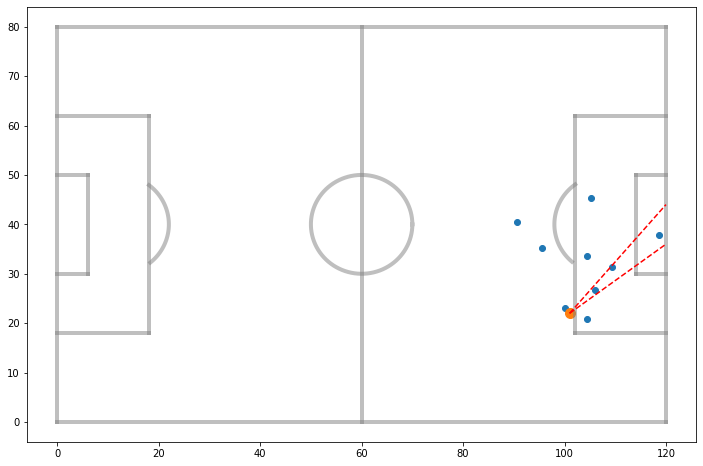

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
draw_pitch(axis=ax, rotate=True)
plot_shot_freeze_frame(la_liga["2018/2019"]['16215'].json_file, "6c30cac4-6f3b-4cd0-9913-26137b058416")

Now I will write a function which takes a json file for a given game, and returns a data frame containing all shots taken along with the variables related to that shot. Then I will write two wrapper function: `get_shots_for_season` which calls `get_shots_for_game` on all game files for that season, and `get_shots_for_league`, which does a similar thing, but for each game across every season we have for that league.

In [204]:
def get_shots_for_game(game_json):
    """
    Function which parses through a game JSON and return a data frame containing all shots taken in that game with several features 
    related to that shot
    
    Arguments
    game_json - event level json for a game
    """
    
    #features for each shot, which will be the columns of our data frame
    shot_id_list = []
    x_start_location_list = []
    y_start_location_list = []
    play_pattern_list = []
    duration_list = []
    outcome_list = []
    technique_list = []
    type_shot_list = []
    first_time_list = []
    x_gk_pos_list = []
    y_gk_pos_list = []
    num_opponents_5_yards_list = []
    num_opponents_between_goal_list = []
    
    statsbomb_xg = [] #to compare to my model
    
    #-------------------------#

    for events in game_json:
    
        if events['type']['name'] == 'Shot':
        
            #get data for first 8 features
            shot_id = events['id']
            x_start_location = events['location'][0]
            y_start_location = events['location'][1]
            play_pattern = events['play_pattern']['name']
            duration = events['duration']
            outcome = events['shot']['outcome']['name'] 
            technique = events['shot']['technique']['name']
            type_shot = events['shot']['type']['name']
            xg = events['shot']['statsbomb_xg']
        
            #check if json shot has a first_time attribute, if not set first_time to False
            if 'first_time' in events['shot']:
                first_time = events['shot']['first_time']
            else:
                first_time = False
            
            #check if shot has a freeze_frame dictionary
            if "freeze_frame" in events["shot"]:
                
                num_opponents_5_yards = 0
                num_opponents_between_goal = 0
                
                for player in events["shot"]["freeze_frame"]:
                    x_player = player['location'][0]
                    y_player = player['location'][1]
                    
                    #count how many opponents were within 5 yards of player when shot was taken
                    if ((x_start_location - x_player)**2 + (y_start_location - y_player)**2) <= 25 and (player['teammate'] == False):
                        if (player['position']['name'] != 'Goalkeeper'):
                            num_opponents_5_yards += 1
                    
                    #count how many opponents were between shot and goal
                    if (player['teammate'] == False) and (player['position']['name'] != 'Goalkeeper'):
                        if check_player_btwn_shot_and_goal(x_start_location, y_start_location, x_player, y_player):
                            num_opponents_between_goal += 1
                    
                    #get position of opponent's goalkeeper 
                    if ((player['position']['name'] == 'Goalkeeper') and (player['teammate'] == False)):
                        x_gk_pos = player['location'][0]
                        y_gk_pos = player['location'][1]
            
            #if there is no freeze frame, assume goalkeeper is at center of goal, and 0 opponenets around shot location
            else:
                num_opponents_between_goal = 0
                num_opponents_5_yards = 0
                x_gk_pos = 120
                y_gk_pos = 40            
            
            #append data on shot to relevant list (column)
            shot_id_list.append(shot_id)
            play_pattern_list.append(play_pattern)
            x_start_location_list.append(x_start_location)
            y_start_location_list.append(y_start_location)
            duration_list.append(duration)
            outcome_list.append(outcome)
            technique_list.append(technique)
            first_time_list.append(first_time)
            x_gk_pos_list.append(x_gk_pos)
            y_gk_pos_list.append(y_gk_pos)
            type_shot_list.append(type_shot)
            num_opponents_5_yards_list.append(num_opponents_5_yards)
            num_opponents_between_goal_list.append(num_opponents_between_goal)
            statsbomb_xg.append(xg)
        
    #create data frame with column features
    shot_df = pd.DataFrame({
                       "shot id" : shot_id_list,
                       "play pattern" : play_pattern_list, 
                       "x start location" : x_start_location_list, 
                       "y start location" : y_start_location_list,
                       "duration" : duration_list, 
                       "outcome" : outcome_list, 
                       "technique" : technique_list, 
                       "first time" : first_time_list,
                       "x gk position" : x_gk_pos_list,
                       "y gk position" : y_gk_pos_list,
                       "type of shot" : type_shot_list,
                       "num opponents within 5 yards" : num_opponents_5_yards_list,
                       "num opponents between shot and goal" : num_opponents_between_goal_list,
                       "statsbomb xg" : statsbomb_xg
                       })
    
    return shot_df.set_index("shot id")

**Wrapper functions:**

In [249]:
def get_shots_for_season(season_dict):
    """
    Takes a dictionary whichs maps game ids to Game objects, and calls get_shots_for_game() on each one.
    
    Arguments:
    season_dict - dictionary which maps game ids (string, as specified by statsbomb) to Game objects (defined above)
    """
    total_shot_df = pd.DataFrame()
    
    for keys, values in season_dict.items():
        shot_df = get_shots_for_game(values.json_file)
        shot_df["game_id"] = keys
        total_shot_df = total_shot_df.append(shot_df)
        
    return total_shot_df


def get_shots_for_league(league_dict):
    """
    Takes a dictionary which maps season names to season dictionaries for a league, and calls get_shots_for_game() on each game.
    
    Arguments:
    league_dict - dictionary which maps season names to another dictionary. This inner dictionary maps 
    game ids (as specified by statsbomb) to Game objects (defined above)
    """
    total_shot_df = pd.DataFrame()
    
    for keys, values in league_dict.items():
        shot_df = get_shots_for_season(values)
        shot_df["season_id"] = keys
        total_shot_df = total_shot_df.append(shot_df)
        print("Getting shots for " + keys)
    
    print("Done.")
    
    return total_shot_df

In [250]:
all_la_liga_shots = get_shots_for_league(la_liga)

Getting shots for 2018/2019
Getting shots for 2017/2018
Getting shots for 2016/2017
Getting shots for 2015/2016
Getting shots for 2014/2015
Getting shots for 2013/2014
Getting shots for 2012/2013
Getting shots for 2011/2012
Getting shots for 2010/2011
Getting shots for 2009/2010
Getting shots for 2008/2009
Getting shots for 2007/2008
Getting shots for 2006/2007
Getting shots for 2005/2006
Getting shots for 2004/2005
Done.


So we have our data frame with all shots taken in Barca games from 2004/05 to 2015/16.

In [251]:
all_la_liga_shots

,play pattern,x start location,y start location,duration,outcome,technique,first time,x gk position,y gk position,type of shot,num opponents within 5 yards,num opponents between shot and goal,statsbomb xg,game_id,season_id
shot id,,,,,,,,,,,,,,,
6c30cac4-6f3b-4cd0-9913-26137b058416,From Throw In,101.0,22.0,1.179654,Saved,Normal,False,118.6,37.9,Open Play,2,2,0.020549,16215,2018/2019
67cfa552-952c-4f72-a33a-0dd6af217a66,From Throw In,113.7,39.9,1.226969,Saved Off Target,Volley,True,117.2,39.1,Open Play,1,0,0.363959,16215,2018/2019
8c95e369-ec54-4a84-9d3e-51abb6f38e6e,From Free Kick,95.6,44.4,1.046942,Goal,Normal,False,119.5,39.0,Free Kick,0,5,0.127337,16215,2018/2019
2ae506b9-0601-460b-b91d-802296120161,From Free Kick,94.0,46.1,1.375915,Saved,Normal,False,119.1,39.5,Free Kick,0,4,0.090603,16215,2018/2019
10dc9818-a8d2-47f9-b219-9bc87d7b22e6,From Free Kick,104.1,22.2,0.116586,Blocked,Normal,False,118.4,37.4,Open Play,3,1,0.022751,16215,2018/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
da65c5c6-ce8f-46d3-b0b4-17fb1c9e31c3,From Free Kick,93.8,40.1,1.278336,Off T,Normal,True,115.2,42.1,Open Play,0,1,0.042606,68352,2004/2005
805dd74f-323c-412d-9b77-9c54c1a60f66,Regular Play,110.1,40.2,0.671461,Saved,Normal,False,119.4,39.9,Open Play,2,0,0.117359,68352,2004/2005
4eadd318-25f7-420d-8aa9-53685cece638,From Corner,93.7,48.5,0.946505,Saved,Volley,True,119.3,39.9,Open Play,1,3,0.013930,68352,2004/2005


## 2. Data Exploration

Before starting to train our models, we'll want to do some data exploration to get an initial idea of what variables affect the probability of a shot resulting in a goal. Even though, as we'll see, many of the models will select the features for us, this is still a useful exercise as it will give us a more intuitive idea of what the models will be doing. 

Additionally, if we find patterns in the visualizations below that make sense based on what we know about soccer, it will be a sort of "sanity-check" that we have accurately extracted the shot data.

### 2.1 Feature engineering

We will first create the following new variables:

- Distance of shot location from goal
- Convert outcome to a binary variable (Goal = 1, Other = 0). I'm doing this since for now, I don't care if the shot was saved, went wide, etc. I only care if it went in or not.

In [252]:
all_la_liga_shots["Distance from goal"] = np.sqrt((all_la_liga_shots["x start location"] - 120)**2 +    \
                                                  (all_la_liga_shots["y start location"] - 40)**2)

goal_label_mask = all_la_liga_shots["outcome"].str.contains("Goal")
all_la_liga_shots["outcome"].loc[goal_label_mask] = 1
all_la_liga_shots["outcome"].loc[~goal_label_mask] = 0

/Users/robertblumberg/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [253]:
all_la_liga_shots

,play pattern,x start location,y start location,duration,outcome,technique,first time,x gk position,y gk position,type of shot,num opponents within 5 yards,num opponents between shot and goal,statsbomb xg,game_id,season_id,Distance from goal
shot id,,,,,,,,,,,,,,,,
6c30cac4-6f3b-4cd0-9913-26137b058416,From Throw In,101.0,22.0,1.179654,0,Normal,False,118.6,37.9,Open Play,2,2,0.020549,16215,2018/2019,26.172505
67cfa552-952c-4f72-a33a-0dd6af217a66,From Throw In,113.7,39.9,1.226969,0,Volley,True,117.2,39.1,Open Play,1,0,0.363959,16215,2018/2019,6.300794
8c95e369-ec54-4a84-9d3e-51abb6f38e6e,From Free Kick,95.6,44.4,1.046942,1,Normal,False,119.5,39.0,Free Kick,0,5,0.127337,16215,2018/2019,24.793548
2ae506b9-0601-460b-b91d-802296120161,From Free Kick,94.0,46.1,1.375915,0,Normal,False,119.1,39.5,Free Kick,0,4,0.090603,16215,2018/2019,26.705992
10dc9818-a8d2-47f9-b219-9bc87d7b22e6,From Free Kick,104.1,22.2,0.116586,0,Normal,False,118.4,37.4,Open Play,3,1,0.022751,16215,2018/2019,23.867342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
da65c5c6-ce8f-46d3-b0b4-17fb1c9e31c3,From Free Kick,93.8,40.1,1.278336,0,Normal,True,115.2,42.1,Open Play,0,1,0.042606,68352,2004/2005,26.200191
805dd74f-323c-412d-9b77-9c54c1a60f66,Regular Play,110.1,40.2,0.671461,0,Normal,False,119.4,39.9,Open Play,2,0,0.117359,68352,2004/2005,9.902020
4eadd318-25f7-420d-8aa9-53685cece638,From Corner,93.7,48.5,0.946505,0,Volley,True,119.3,39.9,Open Play,1,3,0.013930,68352,2004/2005,27.639465


### 2.2 Create a training and test set

Since I don't want the test set to influence my model in any way (including the data exploration - which could eventually inform how I choose my model), I'll split the data now into test and training sets and stash the test set away until my model is finished.

In [254]:
X_train, X_test, y_train, y_test = train_test_split(all_la_liga_shots.drop(["outcome"], axis=1), all_la_liga_shots["outcome"], test_size=0.2)

shot_training_set = pd.merge(X_train, y_train, left_index=True, right_index=True)
shot_test_set = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [255]:
shot_training_set

,play pattern,x start location,y start location,duration,technique,first time,x gk position,y gk position,type of shot,num opponents within 5 yards,num opponents between shot and goal,statsbomb xg,game_id,season_id,Distance from goal,outcome
shot id,,,,,,,,,,,,,,,,
429197f3-82e4-4745-a44d-53d48fb8a25a,From Free Kick,82.2,42.2,1.428466,Normal,False,118.5,40.0,Free Kick,0,0,0.014002,9682,2017/2018,37.863967,0
d66b3f02-3526-4a5c-9d29-339bf0b10d7f,Regular Play,112.0,20.0,0.808000,Normal,False,119.2,36.2,Open Play,3,0,0.018279,9700,2017/2018,21.540659,0
08c5cfcc-e63c-41d6-8868-6c99dda92d76,From Corner,93.1,50.2,2.627000,Half Volley,True,119.2,42.8,Open Play,0,2,0.014953,69343,2011/2012,28.768907,0
21b8b7dc-7711-4437-b8f5-bb5ab1ed4765,From Throw In,111.9,52.9,0.500035,Normal,False,115.5,48.4,Open Play,1,1,0.149301,16073,2018/2019,15.232203,1
0621f240-203b-46b2-a822-291671b54f38,Regular Play,106.3,44.2,1.058642,Volley,False,118.1,42.4,Open Play,2,0,0.058536,69326,2011/2012,14.329341,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ea3bf932-c859-4bb8-bed9-ba3cd4b4c165,From Throw In,112.9,49.1,0.415300,Normal,False,117.7,43.8,Open Play,2,0,0.115852,70304,2012/2013,11.542097,1
8ac81ead-0b86-47c4-ab20-5f0a79c77065,From Corner,113.8,44.9,0.731139,Overhead Kick,True,118.3,42.0,Open Play,2,0,0.211582,267597,2014/2015,7.902531,0
f3518759-3eaf-4d47-9bb0-7b5f4f8a948e,From Keeper,110.2,33.9,1.164571,Normal,False,113.3,37.3,Open Play,1,1,0.361381,69177,2008/2009,11.543396,1


### 2.3 Visualizing relationships

Below, I write a function, `plot_percent_goal_vs_attr` to plot the percentage of goals scored by desired **categorical** variable.

In [256]:
def plot_percent_goal_vs_attr(attribute, type_chart = "line"):
    """
    Function which plots the percentage of goals scored by desired categorical attribute in our shot training set.
    
    Arguments
    attribute - (string) name of categorical attribute in shot training set data frame
    """
    shot_training_set_copy = shot_training_set.copy() 
    
    attr_x = attribute
    attr_y = "outcome"
    attr_agg = "shot id"
    attrs = [attr_x, attr_y, attr_agg]

    outcomes_by_attribute = shot_training_set_copy.reset_index()[attrs]   \
                            .groupby([attr_x, attr_y])               \
                            .count()                                 \
                            .unstack()                               \
                            .fillna(0)
    
    outcomes_by_attribute = outcomes_by_attribute[attr_agg].reset_index()
    outcomes_by_attribute["Percent Goal"] = outcomes_by_attribute[1] * 100  / outcomes_by_attribute.sum(axis = 1)
    outcomes_by_attribute = outcomes_by_attribute.rename(columns={0: 'No Goal', 1: 'Goal'})
    
    if type_chart == "line":
        chart = alt.Chart(outcomes_by_attribute).mark_line()
    elif type_chart == "bar":
        chart = alt.Chart(outcomes_by_attribute).mark_bar()
    
    chart = chart.encode(
        alt.X('{}:N'.format(attr_x), axis = alt.Axis(title = attr_x, labelAngle = 0)),
        alt.Y('Percent Goal:Q', axis = alt.Axis(title = 'Percent Goal'))
    ).properties(width = 850, height = 300, 
             title = "Percent Goal vs {}".format(attr_x)
    ).configure_axis(labelFontSize = 13, titleFontSize = 15
    ).configure_title(fontSize = 16)
    
    return chart

#### 2.3.1 Percent goals by num opponents between shot and goal

Now we can use our function to plot the desired variables:

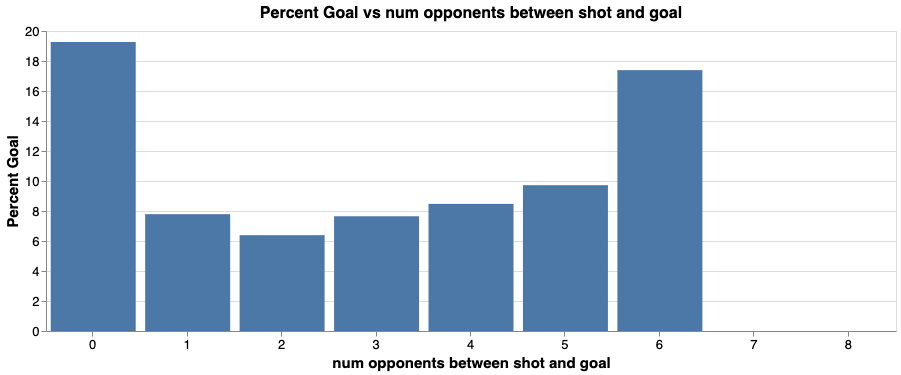

In [257]:
plot_percent_goal_vs_attr("num opponents between shot and goal", "bar")

**Comments:**

As expected, in general, the rate of goals scored decreases as more opponents are between the shot location and the goal. Interestingly, there is a bizarre peak at 6 opponents between shot and goal.

#### 2.3.2 Percent goals by num opponents within 5 yards

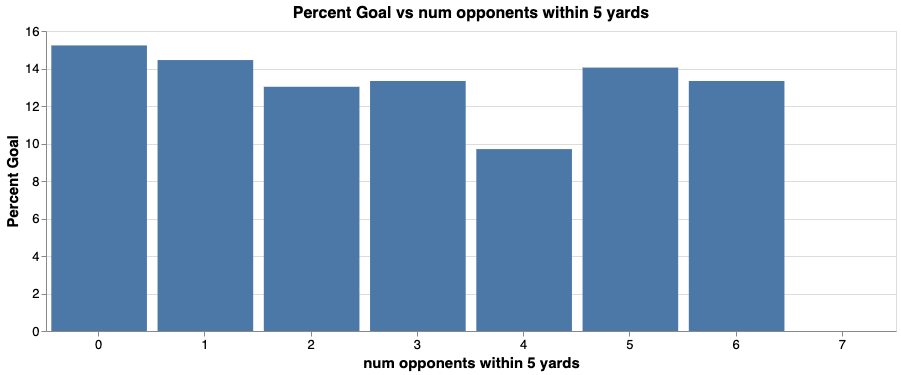

In [258]:
plot_percent_goal_vs_attr("num opponents within 5 yards", "bar")

**Comments:**

We see a similar trend for rate of goals scored vs number of opponents within 5 yards of shot location.

#### 2.3.3 Percent goals by player pattern

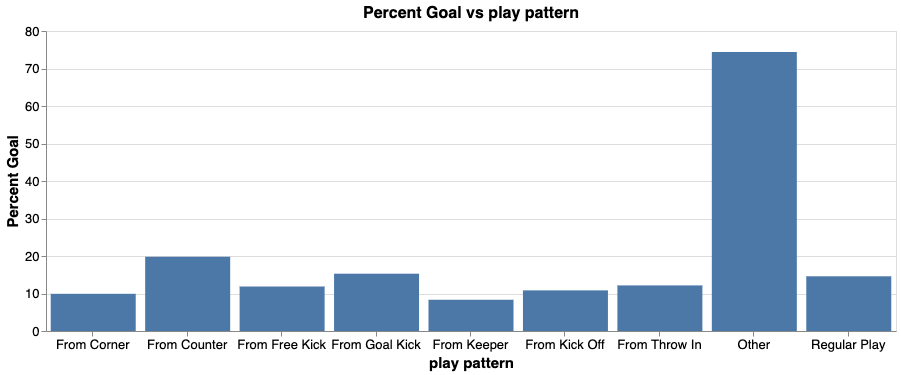

In [259]:
plot_percent_goal_vs_attr("play pattern", "bar")

**Comments:**

For goal scoring rate by _play pattern_, we see that "other" has a very large percent goals scored value. This tells us that "other" refers to penalties. Aside from "other", we can see that shots from counter attacks have a larger chance to produce a goal than any other play pattern, probably because counter attacks mean that the opposition is much less organized, resulting in more space. To be sure, we can check this below:

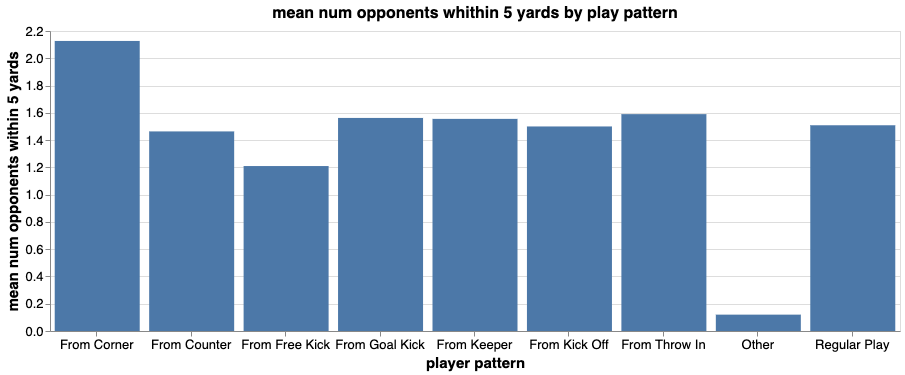

In [260]:
alt.Chart(shot_training_set.groupby("play pattern").mean().reset_index()).mark_bar().encode(
        alt.X('play pattern:N', axis = alt.Axis(title = "player pattern", labelAngle = 0)),
        alt.Y('num opponents within 5 yards:Q', axis = alt.Axis(title = 'mean num opponents within 5 yards'))
).properties(width = 850, height = 300, 
             title = "mean num opponents whithin 5 yards by play pattern"
).configure_axis(labelFontSize = 13, titleFontSize = 15
).configure_title(fontSize = 16)

Ok, so actually, shots resulting from counters, on average, don't have less players within 5 yards of the shot location than other play patterns. What about number of opponents between the shot location and the goal?

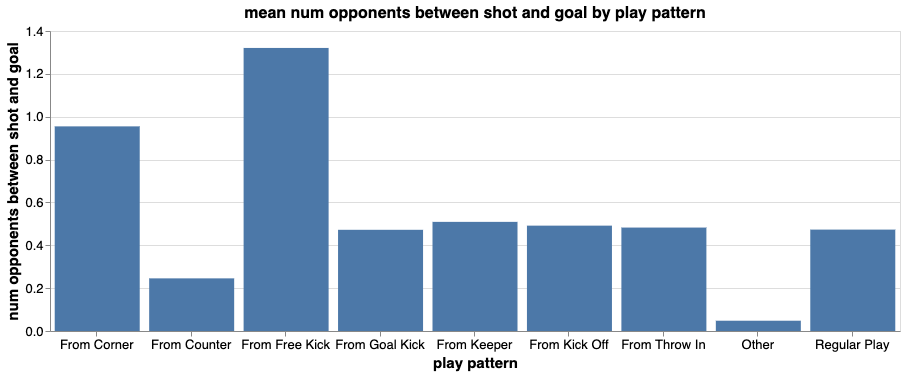

In [261]:
alt.Chart(shot_training_set.groupby("play pattern").mean().reset_index()).mark_bar().encode(
        alt.X('play pattern:N', axis = alt.Axis(title = "play pattern", labelAngle = 0)),
        alt.Y('num opponents between shot and goal:Q', axis = alt.Axis(title = 'num opponents between shot and goal'))
).properties(width = 850, height = 300, 
             title = "mean num opponents between shot and goal by play pattern"
).configure_axis(labelFontSize = 13, titleFontSize = 15
).configure_title(fontSize = 16)

Right, so we can see that actually, shots resulting from counters result in a higher rate of goals scored because there are less opponents between the shot location and the goal (on average), makes sense. 

#### 2.3.3 Percent goals by first time 

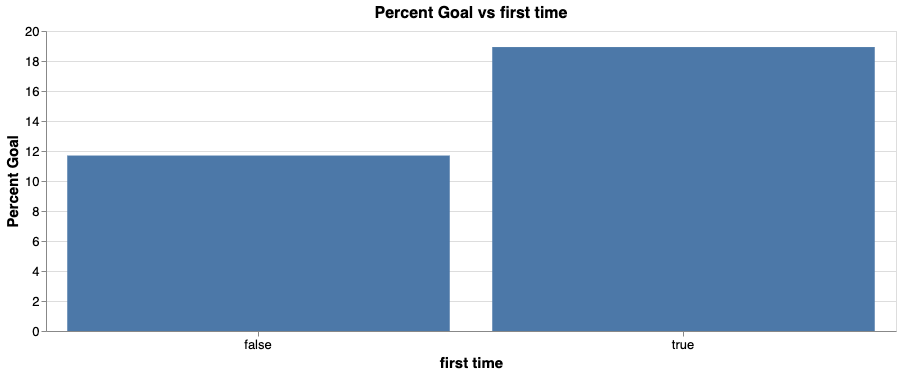

In [262]:
plot_percent_goal_vs_attr("first time", "bar")

Above, we see that shots taken "first time" have a higher chance of resulting in a goal that those not taken first time. If all things were equal, this wouldn't make much intuitive sense. But in this case, shots taken first time likely had other favorable conditions which would increase their chance of resulting in a goal. Let's see if this is true:

In [263]:
shot_training_set.groupby("first time").mean().reset_index()

,first time,x start location,y start location,duration,x gk position,y gk position,num opponents within 5 yards,num opponents between shot and goal,statsbomb xg,Distance from goal,outcome
0,False,102.884303,39.253960,0.801998,117.831490,39.897371,1.596335,0.760159,0.107894,20.203440,0.116972
1,True,105.732661,39.957284,0.753124,117.457761,39.969431,1.322569,0.658716,0.173646,16.955988,0.189358


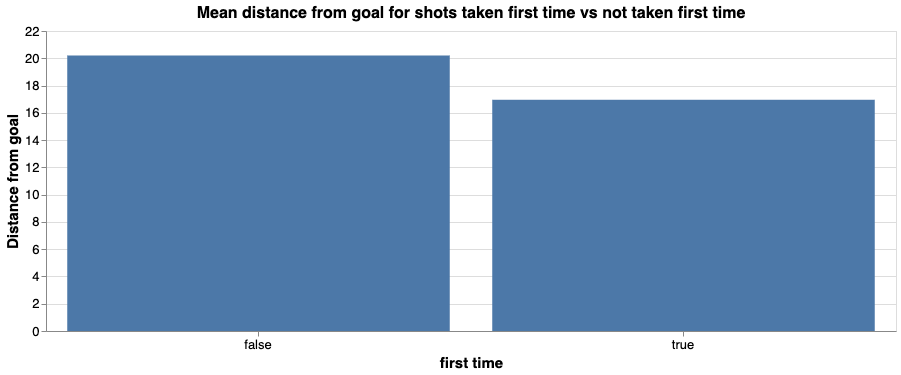

In [264]:
alt.Chart(shot_training_set.groupby("first time").mean().reset_index()).mark_bar().encode(
        alt.X('first time:N', axis = alt.Axis(title = "first time", labelAngle = 0)),
        alt.Y('Distance from goal:Q', axis = alt.Axis(title = 'Distance from goal'))
).properties(width = 850, height = 300, 
             title = "Mean distance from goal for shots taken first time vs not taken first time"
).configure_axis(labelFontSize = 13, titleFontSize = 15
).configure_title(fontSize = 16)

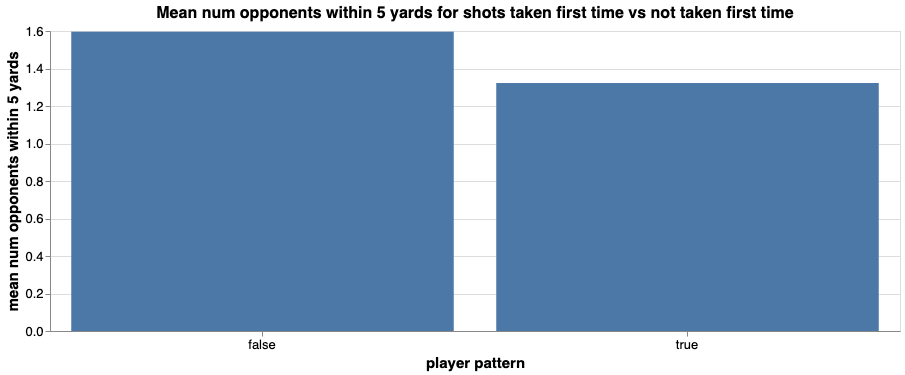

In [265]:
alt.Chart(shot_training_set.groupby("first time").mean().reset_index()).mark_bar().encode(
        alt.X('first time:N', axis = alt.Axis(title = "player pattern", labelAngle = 0)),
        alt.Y('num opponents within 5 yards:Q', axis = alt.Axis(title = 'mean num opponents within 5 yards'))
).properties(width = 850, height = 300, 
             title = "Mean num opponents within 5 yards for shots taken first time vs not taken first time"
).configure_axis(labelFontSize = 13, titleFontSize = 15
).configure_title(fontSize = 16)

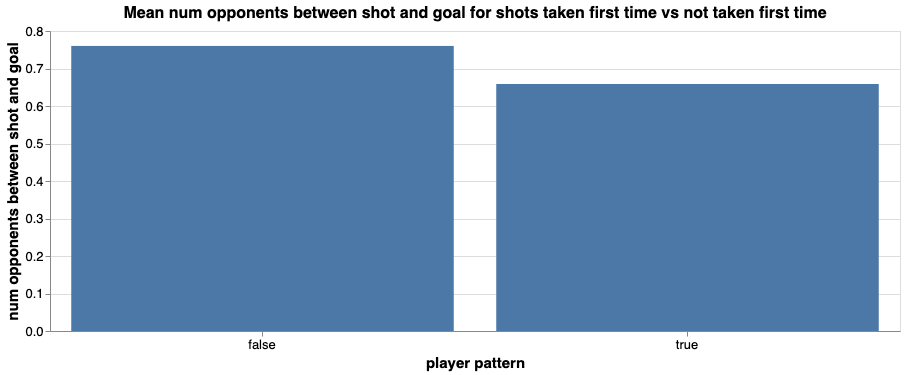

In [266]:
alt.Chart(shot_training_set.groupby("first time").mean().reset_index()).mark_bar().encode(
        alt.X('first time:N', axis = alt.Axis(title = "player pattern", labelAngle = 0)),
        alt.Y('num opponents between shot and goal:Q', axis = alt.Axis(title = 'num opponents between shot and goal'))
).properties(width = 850, height = 300, 
             title = "Mean num opponents between shot and goal for shots taken first time vs not taken first time"
).configure_axis(labelFontSize = 13, titleFontSize = 15
).configure_title(fontSize = 16)

So just as we guessed, shots taken first time are, on average, slightly closer to the goal and are taken with less opponents between the shot location and the goal, and within 5 yards of the shot location.

## 3. Data preprocessing

So in the previous section, we explored our data, and most of our findings made intuitive sense. Now, we will create pipelines for preprocessing the categorical and numerical attributes in our shot data frame, then combine the two pipelines. To refresh our memories, here is the shot data frame again:

In [267]:
shot_training_set.head()

,play pattern,x start location,y start location,duration,technique,first time,x gk position,y gk position,type of shot,num opponents within 5 yards,num opponents between shot and goal,statsbomb xg,game_id,season_id,Distance from goal,outcome
shot id,,,,,,,,,,,,,,,,
429197f3-82e4-4745-a44d-53d48fb8a25a,From Free Kick,82.2,42.2,1.428466,Normal,False,118.5,40.0,Free Kick,0,0,0.014002,9682,2017/2018,37.863967,0
d66b3f02-3526-4a5c-9d29-339bf0b10d7f,Regular Play,112.0,20.0,0.808000,Normal,False,119.2,36.2,Open Play,3,0,0.018279,9700,2017/2018,21.540659,0
08c5cfcc-e63c-41d6-8868-6c99dda92d76,From Corner,93.1,50.2,2.627000,Half Volley,True,119.2,42.8,Open Play,0,2,0.014953,69343,2011/2012,28.768907,0
21b8b7dc-7711-4437-b8f5-bb5ab1ed4765,From Throw In,111.9,52.9,0.500035,Normal,False,115.5,48.4,Open Play,1,1,0.149301,16073,2018/2019,15.232203,1
0621f240-203b-46b2-a822-291671b54f38,Regular Play,106.3,44.2,1.058642,Volley,False,118.1,42.4,Open Play,2,0,0.058536,69326,2011/2012,14.329341,0


First, we create a class `AttrSelector`, which has methods `fit` and `transform` that we can use in our pipeline. This method will be use to select the features in our data frame for each pipeline.

Also, by making this class a subclass of `BaseEstimator` and `TransformerMixin`, we get the `fit_transform`, `get_params()` and `set_params()` methods as well.

In [268]:
class AttrSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes):
        self.attributes = attributes
   
    def fit(self, attributes):
        return self
    
    def transform(self, X):
        return X[self.attributes]

### 3.1 Categorical pipeline

In our categorical pipeline, we will use AttrSelector to select the relevant categorical attributes, stored as a list in the _categorical_shot_attributes_ variable. We then encode the values of each categorical variable as "One hot vector". 

In [269]:
categorical_shot_attributes = ["play pattern", "technique", "first time"]

categorical_attr_pipeline = Pipeline([
    ('selector', AttrSelector(categorical_shot_attributes)),
    ('one_hot_encoder',  OneHotEncoder())
])

In [270]:
one_hot_vals_play_pattern = shot_training_set["play pattern"].unique()
one_hot_vals_technique = shot_training_set["technique"].unique()
one_hot_vals_first_time = shot_training_set["first time"].unique()

one_hot_categorical_features = np.concatenate([one_hot_vals_play_pattern, one_hot_vals_technique, one_hot_vals_first_time])

### 3.2 Numerical pipeline

In our numerical pipeline, we will use AttrSelector to select the relevant numerical attributes, stored as a list in the _numerical_shot_attributes_ variable.

In [271]:
numerical_shot_attributes = ["x start location", "y start location", "x gk position", "y gk position", 
                             "num opponents within 5 yards", "num opponents between shot and goal", "Distance from goal"]

numerical_attr_pipeline = Pipeline([
    ('selector', AttrSelector(numerical_shot_attributes))
])

numerical_features = np.array(numerical_shot_attributes)

### 3.3 Combined pipeline

Now we combine the categorical and numerical pipelines using the `FeatureUnion` class. And we get our data frame transformed into a sparse matrix, ready to be passed through to sklearn models.

In [272]:
combined_pipeline = FeatureUnion(transformer_list = [
    ("categorical_attr_pipeline", categorical_attr_pipeline),
    ("numerical_attr_pipeline", numerical_attr_pipeline)
])

X_train = combined_pipeline.fit_transform(shot_training_set)
X_test = combined_pipeline.transform(shot_test_set)

In [273]:
#list containing names of all features (including new one-hot features)
total_features = np.concatenate([one_hot_categorical_features, numerical_features])

## 4. Models

### 4.1 Logistic Regression

#### 4.1.1 Grid search over C

In [275]:
C_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
mse_list = []

for C in C_vals:
    k_folds = KFold(n_splits=5, shuffle=True, random_state=24)
    k_folds.split(X_train)
    for train_index, val_index in k_folds.split(X_train):
        mse_C = []
        X_train_cv, X_val = X_train[train_index], X_train[val_index]
        y_train_cv, y_val = y_train[train_index], y_train[val_index]
       
        lr_model = LogisticRegression(solver="liblinear", C=C)
        lr_model.fit(X_train_cv, y_train_cv)
        mse_C = np.mean((lr_model.predict_proba(X_valid)[:, 1] - y_valid)**2)
    mse_list.append(np.mean(mse_C))

In [276]:
pd.DataFrame({"C" : C_vals,
              "mean validation mse": mse_list})

,C,mean validation mse
0,0.0001,0.106675
1,0.0010,0.104216
2,0.0100,0.101532
3,0.1000,0.099134
4,1.0000,0.097779
5,10.0000,0.096310
6,100.0000,0.096380
7,1000.0000,0.096513
8,10000.0000,0.096425


#### 4.1.2 Fitting model

Ok, so we see that $C=10$ produces the best mean mse on the validation sets, before leveliing off. So let's train a model using this value on the entire training set.

In [277]:
lr_model = LogisticRegression(solver='liblinear', C=10)
lr_model.fit(X_train, y_train)
xg_vals = lr_model.predict_proba(X_test)[:, 1]
xg_model_results = shot_test_set.copy()
xg_model_results["xG"] = xg_vals
xg_model_results["diff"] = xg_model_results["xG"] - xg_model_results["statsbomb xg"]
xg_model_results = xg_model_results.reset_index().set_index(["season_id", "game_id", "shot id"]).sort_values("diff", ascending=False)

In [278]:
print(np.mean((xg_model_results["xG"]-xg_model_results["outcome"])**2))
print(np.mean((xg_model_results["statsbomb xg"]-xg_model_results["outcome"])**2))

0.09100759794642373
0.08529527203859426


In [342]:
xg_model_results.sort_values("xG", ascending=False).iloc[0:6]

,,,play pattern,x start location,y start location,duration,technique,first time,x gk position,y gk position,type of shot,num opponents within 5 yards,num opponents between shot and goal,statsbomb xg,Distance from goal,outcome,xG,diff
season_id,game_id,shot id,,,,,,,,,,,,,,,,
2010/2011,69245,582ddf67-b9dd-4c29-b50e-ebb043fd5f5a,From Free Kick,28.0,37.3,1.260180,Normal,False,0.9,41.3,Free Kick,0,0,0.241625,92.039611,0,0.997175,0.755550
2007/2008,69186,40e85b73-2e34-4d25-a398-adee3663b930,Regular Play,114.4,41.7,0.705506,Normal,False,93.7,31.0,Open Play,0,0,0.872316,5.852350,1,0.964994,0.092678
2011/2012,69340,d3b73047-3292-48ea-93d1-f854e221a4d6,Regular Play,112.1,41.8,0.990900,Half Volley,False,96.1,41.7,Open Play,1,0,0.930032,8.102469,1,0.886122,-0.043910
2015/2016,266254,badea01a-1aa0-4ca6-8671-6c262b9ec6b8,Other,112.3,44.5,0.324395,Normal,False,117.4,42.4,Open Play,1,0,0.502091,8.918520,1,0.828742,0.326651
2012/2013,70280,276c1a49-01fc-4405-bc80-267d40880b78,Other,113.1,37.4,0.780200,Normal,False,117.7,39.1,Open Play,2,0,0.337916,7.373602,0,0.824757,0.486841
2018/2019,16182,a770c00c-0efc-4101-a3bb-41f6b87e7e5f,Other,111.5,45.1,0.901400,Normal,False,118.5,43.4,Open Play,1,0,0.151043,9.912618,0,0.782685,0.631643


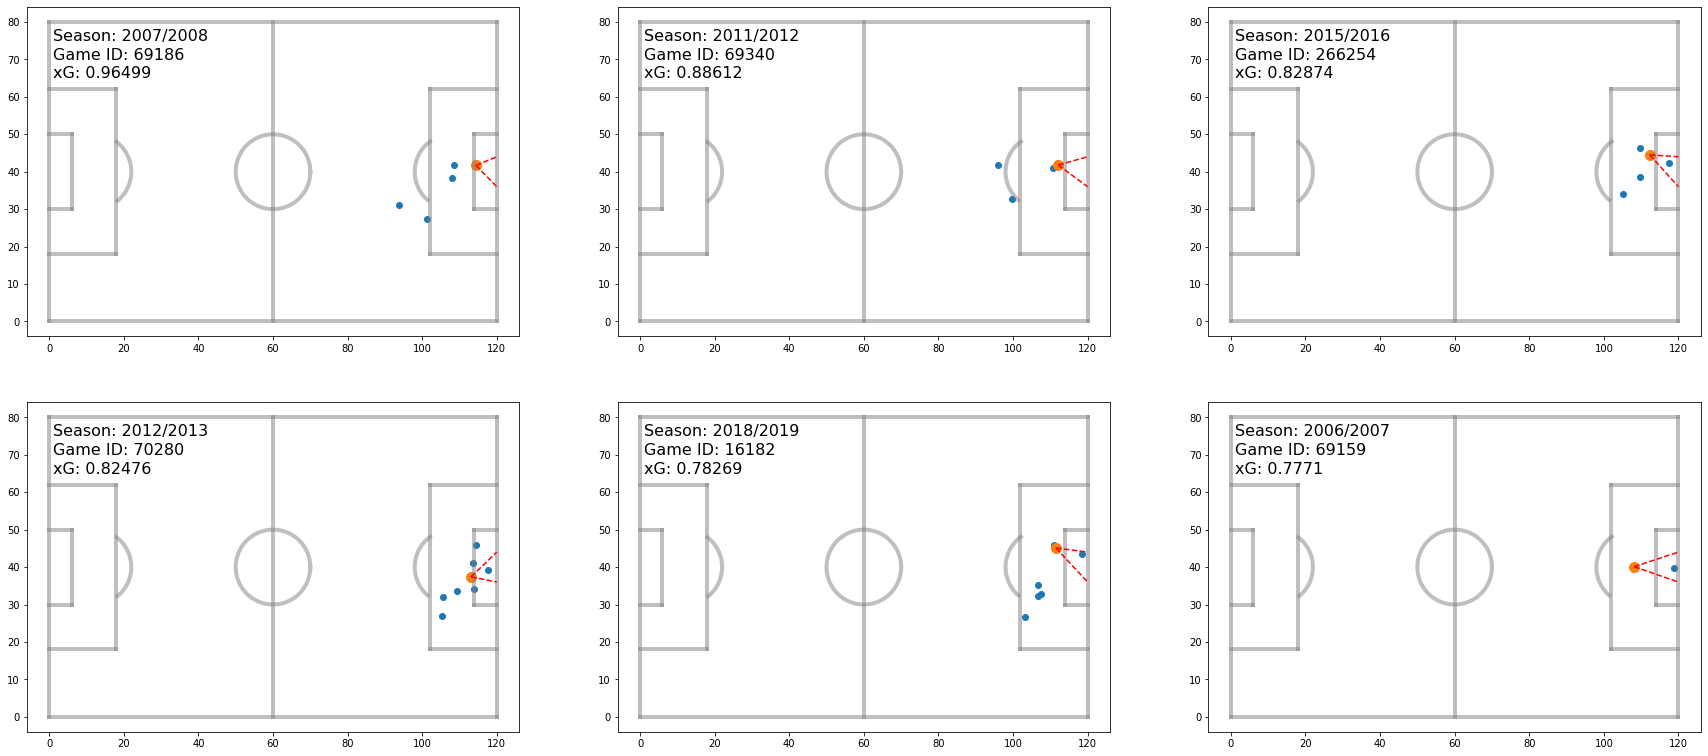

In [355]:
ascending=False
season_ids = xg_model_results.sort_values("xG", ascending=ascending).reset_index().iloc[1:7]["season_id"]
game_ids = xg_model_results.sort_values("xG", ascending=ascending).reset_index().iloc[1:7]["game_id"]
shot_ids = xg_model_results.sort_values("xG", ascending=ascending).reset_index().iloc[1:7]["shot id"]
xg_vals = xg_model_results.sort_values("xG", ascending=ascending).reset_index().iloc[1:7]["xG"]

num=1
fig, ax = plt.subplots(2, 3, figsize=(36/1.2, 16/1.2))
for i in range(2):
    for j in range(3):
        ax_i = ax[i, j]
        draw_pitch(axis=ax_i, rotate=True)
        plot_shot_freeze_frame(la_liga[season_ids[num]][game_ids[num]].json_file, shot_ids[num], ax=ax_i)
        ax_i.annotate("Season: {}".format(season_ids[num]), xy = (1,75), size=16)
        ax_i.annotate("Game ID: {}".format(game_ids[num]), xy = (1,70), size=16)
        ax_i.annotate("xG: {}".format(round(xg_vals[num], 5)), xy = (1,65), size=16)
        num+=1

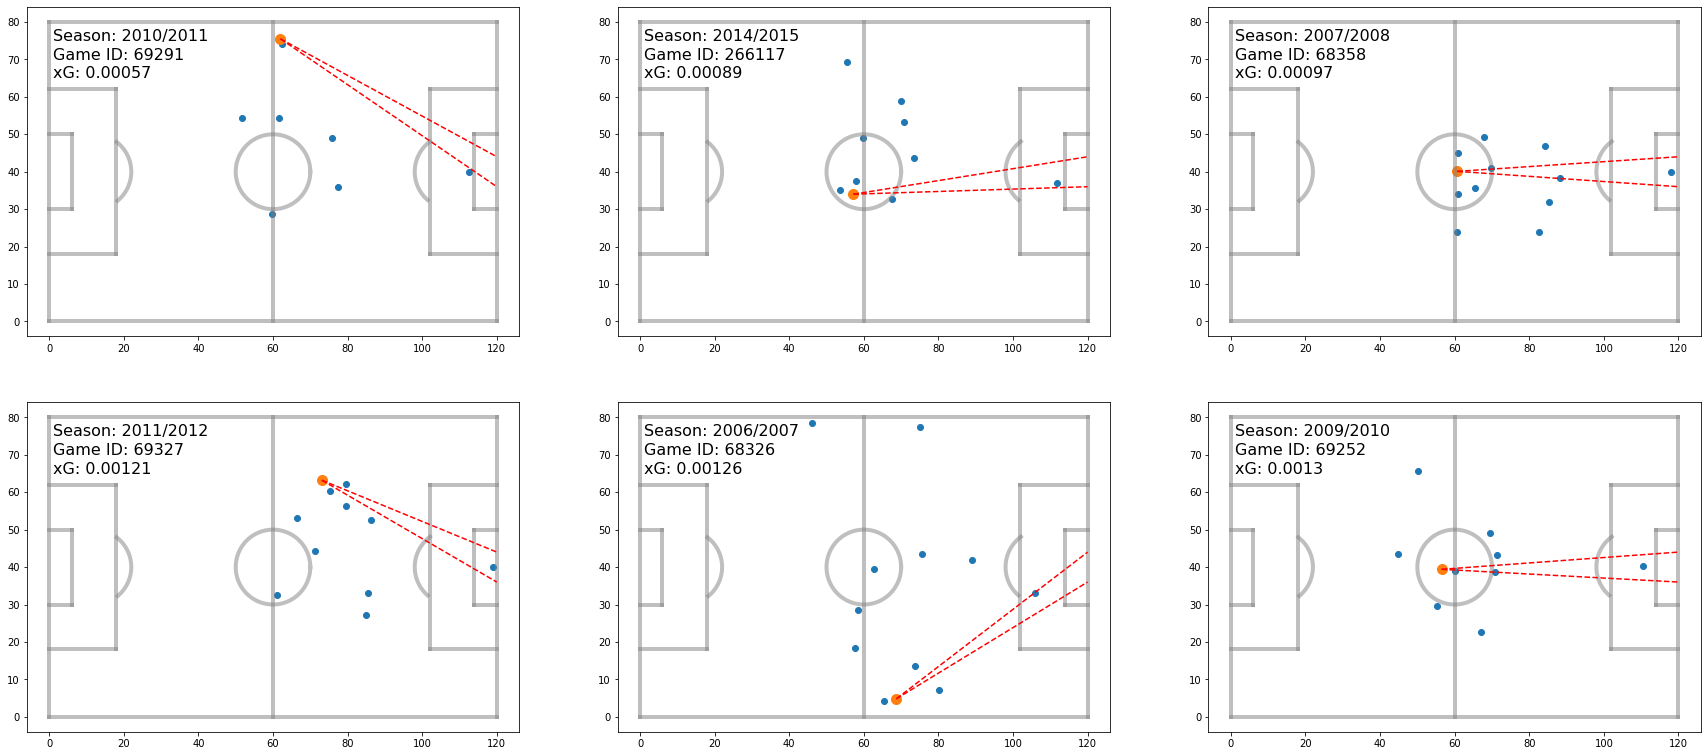

In [356]:
ascending=True
season_ids = xg_model_results.sort_values("xG", ascending=ascending).reset_index().iloc[1:7]["season_id"]
game_ids = xg_model_results.sort_values("xG", ascending=ascending).reset_index().iloc[1:7]["game_id"]
shot_ids = xg_model_results.sort_values("xG", ascending=ascending).reset_index().iloc[1:7]["shot id"]
xg_vals = xg_model_results.sort_values("xG", ascending=ascending).reset_index().iloc[1:7]["xG"]

num=1
fig, ax = plt.subplots(2, 3, figsize=(36/1.2, 16/1.2))
for i in range(2):
    for j in range(3):
        ax_i = ax[i, j]
        draw_pitch(axis=ax_i, rotate=True)
        plot_shot_freeze_frame(la_liga[season_ids[num]][game_ids[num]].json_file, shot_ids[num], ax=ax_i)
        ax_i.annotate("Season: {}".format(season_ids[num]), xy = (1,75), size=16)
        ax_i.annotate("Game ID: {}".format(game_ids[num]), xy = (1,70), size=16)
        ax_i.annotate("xG: {}".format(round(xg_vals[num], 5)), xy = (1,65), size=16)
        num+=1